In [1]:
import torch
import torchphysics as tp
X = tp.spaces.R1('x')
Y = tp.spaces.R1('y')
H = tp.spaces.R1("h")
U = tp.spaces.R1('u')
V = tp.spaces.R1('v')
F_X = tp.spaces.R1('fx')
F_Y = tp.spaces.R1('fy')

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.device_count()

1

In [3]:
X_interval = tp.domains.Interval(X, 0, 2.0) # <-add the bounds of the Interval (0, 2)
Y_interval = tp.domains.Interval(Y, 0, 2.0)
H_interval = tp.domains.Interval(H, 1, 500)
Sim_domain = X_interval*Y_interval*H_interval


In [4]:

bound_sampler_low = tp.samplers.RandomUniformSampler(Y_interval.boundary_left*X_interval*H_interval, n_points=250)

bound_sampler_up = tp.samplers.RandomUniformSampler(Y_interval.boundary_right*X_interval*H_interval, n_points=250)


In [5]:
def IBM_filter(y):
    return y[...,0]<0.4
    
IBM_sampler = tp.samplers.RandomUniformSampler(Sim_domain,n_points=1000,filter_fn=IBM_filter)

In [6]:
def IBM_filter_2(y):
    return (y[...,0]<0.4)&(y[...,0]>0.3)
    
IBM_sampler_2 = tp.samplers.RandomUniformSampler(Sim_domain,n_points=1000,filter_fn=IBM_filter_2)

In [7]:
def Inner_filter(y):
    return y[...,0]>=0.4

inner_sampler = tp.samplers.RandomUniformSampler(Sim_domain, n_points=8000,filter_fn=Inner_filter)

We need a neural network that should learn our solution:

In [8]:
model = tp.models.FCN(input_space=X*Y*H, output_space=U*V, hidden=(50,50,50,50,50,50))#######Activation????

In [9]:
inte_sampler = tp.samplers.RandomUniformSampler(X_interval.boundary*Y_interval, n_points=250)
x_inlet_sampler=tp.samplers.RandomUniformSampler(X_interval*Y_interval,n_points=250)

In [10]:
def init_bulk(u_integral):
    return u_integral-1
pde_cond_bulk=tp.conditions.IntegroPINNCondition(model,x_inlet_sampler,init_bulk,inte_sampler, weight=1)

In [11]:
def pde_IBM(u,v):
    return torch.sqrt(torch.square(u)+torch.square(v))
pde_cond_IBM = tp.conditions.PINNCondition(model, IBM_sampler, pde_IBM,weight=10,name='IBM')

In [12]:
def pde_IBM_2(u,v):
    return torch.sqrt(torch.square(u)+torch.square(v))
pde_cond_IBM_2 = tp.conditions.PINNCondition(model, IBM_sampler_2, pde_IBM_2,weight=10,name='IBM_2')

In [13]:
def pde_mass(u,v,x,y):
    return tp.utils.grad(u,x)+tp.utils.grad(v,y)-0.0
pde_cond_mass = tp.conditions.PINNCondition(model, inner_sampler,pde_mass, weight=1,name='Conti')

In [14]:
def pde_residual_x(u,v, x, y,h):
    residual_momentum= u*tp.utils.grad(u,x)+ v*tp.utils.grad(u,y)+(-tp.utils.laplacian(u, x)-tp.utils.laplacian(u,y))/h + 20
    return residual_momentum

pde_cond_x = tp.conditions.PINNCondition(model, inner_sampler, pde_residual_x, pde_IBM,weight=10,name='Momentum_x')

In [15]:
def pde_residual_y(u,v, x, y,h):
    residual_momentum= u*tp.utils.grad(v,x)+v*tp.utils.grad(v,y)+(-tp.utils.laplacian(v, x)-tp.utils.laplacian(v,y))/h
    return residual_momentum

pde_cond_y = tp.conditions.PINNCondition(model, inner_sampler, pde_residual_y, pde_IBM,weight=1,name='Momentum_y')

Next for the boundary condition:

In [16]:
def boundary_residual_x(u, x,y):
    return u - 0.0

boundary_cond_x = tp.conditions.PINNCondition(model, bound_sampler_up, boundary_residual_x, weight=1,name='noslip_x')

In [17]:
def boundary_residual_y(v, x,y):
    return v - 0.0

boundary_cond_y = tp.conditions.PINNCondition(model, bound_sampler_up, boundary_residual_y, weight=1,name='noslip_y')

In [18]:

Periodic_sampler=tp.samplers.RandomUniformSampler(Y_interval*H_interval,n_points=1000,filter_fn=Inner_filter)

In [19]:
def periodic_residual_x(u_left,u_right):
    Periodic_condition= u_left - u_right
    return Periodic_condition
periodic_cond_x=tp.conditions.PeriodicCondition(model,X_interval,periodic_residual_x,non_periodic_sampler=Periodic_sampler, weight=1,name='periodic_x')

In [20]:
def periodic_residual_y(v_left,v_right):
    Periodic_condition= v_left - v_right
    return Periodic_condition
periodic_cond_y=tp.conditions.PeriodicCondition(model,X_interval,periodic_residual_y,non_periodic_sampler=Periodic_sampler, weight=1,name='periodic_y')

Before the training we collect all conditions and choose our training procedure:

In [21]:
optim = tp.OptimizerSetting(torch.optim.Adam, lr=0.001,scheduler_class=torch.optim.lr_scheduler.ReduceLROnPlateau,scheduler_args={"patience":1000,"factor":0.8,"verbose":True,"min_lr":0.000005},monitor_lr="train/loss")
#solver = tp.solver.Solver([pde_cond_IBM,pde_cond_mass,boundary_cond_x, pde_cond_x,periodic_cond_x,boundary_cond_y, pde_cond_y,periodic_cond_y], optimizer_setting=optim)
solver = tp.solver.Solver([pde_cond_IBM,pde_cond_IBM_2,boundary_cond_x,boundary_cond_y,periodic_cond_x,periodic_cond_y,pde_cond_x,pde_cond_y,pde_cond_mass], optimizer_setting=optim)

Start the training:

In [22]:
import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers
torch.set_float32_matmul_precision('medium')
comet_logger = pl_loggers.CSVLogger(save_dir="logs/")
trainer = pl.Trainer(gpus=1,# use one GPU
                     max_steps=16000, # iteration number
                     benchmark=True, # faster if input batch has constant size
                     logger=comet_logger, # for writting into tensorboard
                     enable_checkpointing=False) # saving checkpoints
trainer.fit(solver)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:478: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 13.1 K
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
13.1 K    Trainable params
0         Non-trainable params
13.1 K    Total params
0.052     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████████████████████████████████████████▉| 16000/16001 [28:26<00:00,  9.38it/s, loss=19.8, v_num=29]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|███████████████████████████████████████████████| 16001/16001 [28:26<00:00,  9.38it/s, loss=19.8, v_num=29]

`Trainer.fit` stopped: `max_steps=16000` reached.


Epoch 0: 100%|███████████████████████████████████████████████| 16001/16001 [28:26<00:00,  9.38it/s, loss=19.8, v_num=29]


Lastly, we can plot the solution:

In [23]:
import numpy as np

In [24]:
import matplotlib.pyplot as plt

In [25]:
plt.close()

In [26]:
def produce_sample(x_max,y_max,other_Constrains,resolution=100):
    list_x=np.linspace(0,x_max,resolution)
    list_y=np.linspace(0,y_max,resolution)
    XM,YM=np.meshgrid(list_x,list_y)
    model_value_x=np.zeros(XM.shape)
    model_value_y=np.zeros(XM.shape)
    for i in range(len(list_x)):
        for j in range(len(list_y)):
            coords = torch.tensor([[list_x[i],list_y[j],other_Constrains]], dtype=torch.float32)
            model_value_x[i,j] = model(tp.spaces.Points(coords, X*Y*H)).as_tensor[0,0]
            model_value_y[i,j] = model(tp.spaces.Points(coords, X*Y*H)).as_tensor[0,1]
    plt.contourf(XM,YM,model_value_x)
    plt.colorbar()
    plt.plot([0.4,0.4],[0,2])
    return model_value_x


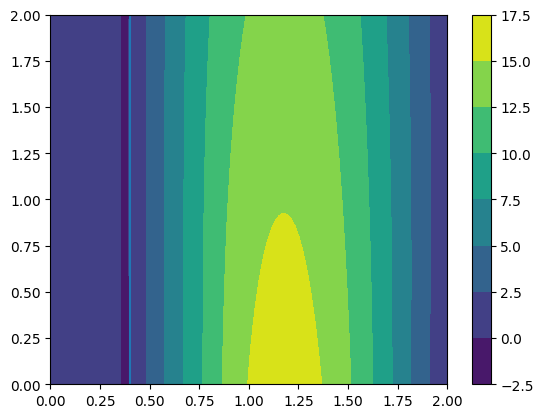

In [27]:
model_values=produce_sample(2,2,50)


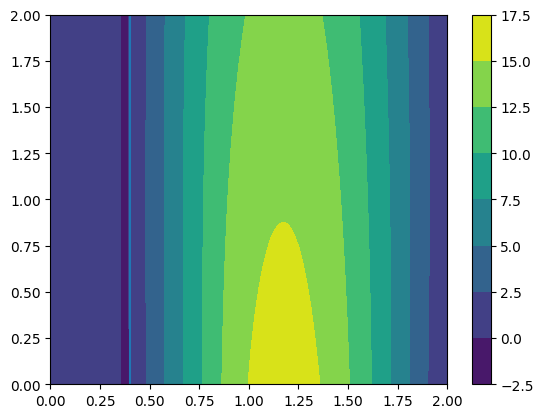

In [28]:
model_values=produce_sample(2,2,100)


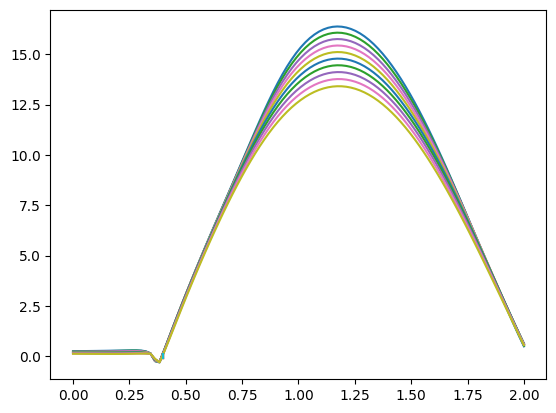

In [29]:
for j in np.linspace(0,2,10):
    coords = torch.tensor([[j,i,30] for i in np.linspace(0,2,100)], dtype=torch.float32)
    model_out = model(tp.spaces.Points(coords, X*Y*H)).as_tensor
    plt.plot(np.linspace(0,2,100),np.array(model_out.transpose(0,1)[0].tolist()))
    plt.plot([0.4,0.4],[0.1,-0.1])

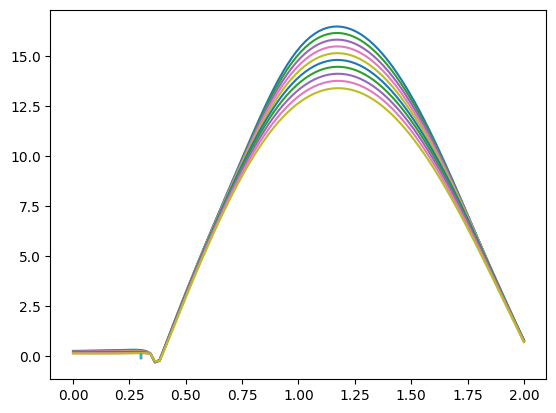

In [30]:
for j in np.linspace(0,2,10):
    coords = torch.tensor([[j,i,20] for i in np.linspace(0,2,100)], dtype=torch.float32)
    model_out = model(tp.spaces.Points(coords, X*Y*H)).as_tensor
    plt.plot(np.linspace(0,2,100),np.array(model_out.transpose(0,1)[0].tolist()))
    plt.plot([0.3,0.3],[0.1,-0.1])

In [31]:
coords = torch.tensor([[5,i] for i in np.linspace(0,2.0,100)], dtype=torch.float32)
model_out = model(tp.spaces.Points(coords, X*Y)).as_tensor
plt.plot(np.array(model_out.transpose(0,1)[0].tolist()))
coords = torch.tensor([[0,i] for i in np.linspace(0,2.0,100)], dtype=torch.float32)
model_out = model(tp.spaces.Points(coords, X*Y)).as_tensor
plt.plot(np.array(model_out.transpose(0,1)[0].tolist()))

ValueError: Points are in Space({'x': 1, 'y': 1}) but should lie
                                     in Space({'x': 1, 'y': 1, 'h': 1}).